# Hits, misses and false alarms
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 31-05-2023<br>


**Introduction**:<br>
This notebooks computes the hits (true positives, $TP$), misses (false negatives, $FN$) and false alarms (false positives, $FP$) for all the selected reporting points and the complete study period.

The input data are the data sets of exceedance over threshold both for the reanalsysis ("observed") and the forecast.

The confusion matrix (hits, misses, false alarms) is computed for all the possible combinations of three criteria: model combination method (named _approach_), persistence, and probability threshold. The values of persisntece and probability thresholds for which the confusion matrix will be evaluated are defined by the user.

The result is a new set of NetCDF files (one for station) that contains matrixes of hits, misses and false alarms for every combination of the criteria.

**Questions**:<br>

* [ ] Take into account the model spread?
* [ ] Aggregate results by river/administrative area? EFAS aims at alerting administrations about incoming events in there administrative area, shouldn't that aggregation be included in the results?
* [ ] Remove extremely bad performing stations.

**Pending tasks**:<br>

* [x] Weighting the model average by the Brier score?
* [x] Sort stations by catchment area (or other order)?
* [x] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.
* [ ] Rename approach 'current' as '1_deterministic_+_1_probabilistic'


**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
import yaml

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from compute import *
from seasonal import disaggregate_by_season
from convert import reshape_DataArray, dict2da
from plot.results import plot_DataArray
from plot.maps import create_cmap
os.chdir(path_root)

## 1 Configuration

In [35]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### 1.1 Reporting points

In [36]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# reporting points
path_stations = cfg.get('reporting_points', {}).get('output', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

### 1.2 Exceedance

In [37]:
# path where results from the preprocessing steps were saved
path_reanalysis = cfg.get('exceedance', {}).get('output', {}).get('reanalysis', f'../results/exceedance/reanalysis/')
path_forecast = cfg.get('exceedance', {}).get('output', {}).get('forecast', f'../results/exceedance/forecast/')

### 1.1 Hits

#### Notification criteria

##### Probability threshold

In [38]:
# probability thresholds
probability_range = cfg.get('hits', {}).get('criteria', {}).get('probability', [.05, .096, .05])
probability = np.arange(*probability_range).round(3)
probability = xr.DataArray(probability, dims=['probability'], coords={'probability': probability})

##### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [39]:
persistence = cfg.get('hits', {}).get('criteria', {}).get('persistence', [(1, 1), (2, 2), (2, 3)])
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

##### Computation of hits

In [40]:
# parameters of the rolling window used to compute hits
window = cfg.get('hits', {}).get('window', 1)
center = cfg.get('hits', {}).get('center', True)

# dissagregate the analysis by seasons?
seasonality = cfg.get('hits', {}).get('seasonality', False)

# path where the dataset of hits, misses and false alarms will be saved
path_out = cfg.get('hits', {}).get('output', f'../results/hits/')
if seasonality:
    path_out += 'seasonal/'
for path in [path_weights, path_out]:
    if os.path.exists(path_out) is False:
        os.makedirs(path_out)
        
# folder where the weighing matrixes will be saved
path_weights = f'{path_out}weighing/'
if not os.path.exists(path_weights):
    os.makedirs(path_weights)

## 2 Data

### 2.1 Reporting points

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [8]:
# load table of fixed reporing points
stations = pd.read_parquet(file_stations)

### 2.2 Exceedance reanalysis

In [9]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = xr.open_mfdataset(f'{path_reanalysis}*.nc', combine='nested', concat_dim='id')['exceedance']
rean_exc = rean_exc.sel(id=stations.index).compute()

if seasonality:
    rean_exc = disaggregate_by_season(rean_exc)

print(rean_exc.dims)
print(rean_exc.shape)

('id', 'datetime')
(2371, 7829)


### 2.3 Exceedance forecast

In [10]:
# load probability of exceeding the discharge threshold in the FORECAST data
fore_exc = xr.open_mfdataset(f'{path_forecast}*.nc', combine='nested', concat_dim='id')
fore_exc['id'] = fore_exc.id.astype(int)
fore_exc = fore_exc.sel(id=stations.index)

# reshape the DataArray of forecasted exceedance
fore_exc = xr.Dataset({label: reshape_DataArray(da, trim=True) for label, da in fore_exc.items()})
fore_exc = fore_exc.transpose('id', 'datetime', 'leadtime', 'model')

# extract starting and ending dates
if ('start' not in locals()) or ('end' not in locals()):
    start = pd.to_datetime(fore_exc.datetime.min().data)
    end = pd.to_datetime(fore_exc.datetime.max().data)

# recalculate the exceedance datasets to convert the 3 classes (>Q5, >0.95·Q5, <0.95·Q5) to only 2 (exceedance, non-exceedance)
rean_exc, fore_exc = recompute_exceedance(rean_exc.sel(datetime=slice(start, end)), fore_exc['high'], fore_exc['low'])

### 2.3 Weighting factors

**Brier weighting**

In [33]:
# COMPUTE BRIER SCORE
brier = {}
for model in fore_exc.model.data:
    # extract model forecast
    pred =  fore_exc.sel(model=model).dropna('leadtime', how='any').transpose()
    # squared error
    se = (pred - rean_exc)**2
    # Brier score
    brier[model] = se.mean(['id', 'datetime'])
# convert dictionary to DatArray
brier = dict2da(brier, dim='model')

# CONVERT BRIER SCORE INTO WEIGHTING FACTORS
e = 1e-5
weights_brier = (brier.max() + e - brier) / (brier.max() + e - brier.min() - e)
weights_brier /= weights_brier.sum('model')

# export
weights_brier.to_netcdf(f'{path_weights}weights_brier.nc')

**Member weighting**

In [28]:
# compute weights by number of members
weights_member = weights_brier.copy()
for model in models:
    weights_member.loc[{'model': model}] = weights_member.sel(model=model).where(weights_brier.sel(model=model).isnull(), models[model]['members'])
weights_member /= weights_member.sum('model')

# export
weights_member.to_netcdf(f'{path_weights}weights_member.nc')

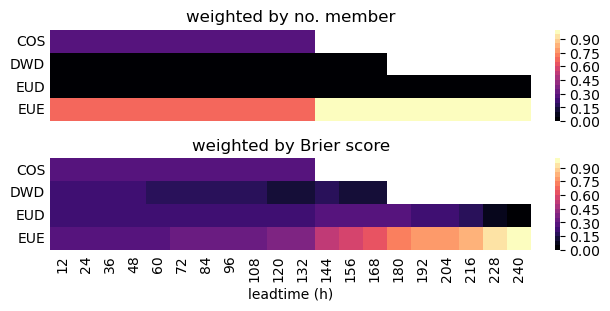

In [30]:
# heatmap of weights
fig, axes = plt.subplots(nrows=2, figsize=(6, 3), constrained_layout=True, sharex=True, sharey=True)
Weights = xr.Dataset({'no. member': weights_member, 'Brier score': weights_brier})
cmap, norm = create_cmap('magma', np.arange(0, 1.01, 0.05), 'weight')
for i, (ax, (var, da)) in enumerate(zip(axes, Weights.items())):
    plot_DataArray(da, cmap=cmap, norm=norm, ax=ax, ytick_step=1, xtick_step=1, title=f'weighted by {var}',# cbar=False)
                         cbar_kwgs={'shrink': .33})
    if i == len(axes) - 1:
        ax.set_xlabel('leadtime (h)')
        
plt.savefig(f'{path_out}/weighing/weighting_matrixes.jpg', dpi=300, bbox_inches='tight')

## 3 Analysis
### 3.1 Hits, misses and false alarms

In [16]:
for stn in tqdm_notebook(stations.index):

    # check if the output file already exists
    file_out = f'{path_out}{stn:>04}.nc'
    if os.path.exists(file_out):
        continue
        
    # FORECAST EXCEEDANCE PROBABILITY
    forecast = fore_exc.sel(id=stn)

    # TOTAL PROBABILITY OF EXCEEDANCE

    # exceedance according to 1 deterministic + 1 probabilistic
    deterministic = (forecast.sel(model=['EUD', 'DWD']) >= probability).any('model')
    probabilistic = (forecast.sel(model=['EUE', 'COS']) >= probability).any('model')
    deterministic_probabilistic = deterministic & probabilistic

    # exceedance according to mean over models
    model_mean = forecast.mean('model', skipna=True) >= probability

    # exceedance according to the mean over models weighted by the number of members
    member_weighted = forecast.weighted(weights_member.fillna(0)).mean('model', skipna=True) >= probability

    # exceedance according to the mean over models weighted by the inverse Brier score
    brier_weighted = forecast.weighted(weights_brier.fillna(0)).mean('model', skipna=True) >= probability

    # merge all total probability approaches in a single DataArray
    total_exc = xr.Dataset({
                            '1_deterministic_+_1_probabilistic': deterministic_probabilistic,
                            'model_mean': model_mean,
                            'member_weighted': member_weighted,
                            'brier_weighted': brier_weighted,
                            }).to_array(dim='approach')

    del forecast

    # HITS, MISSES, FALSE ALARMS
      
    hits = {}
    for label, pers in persistence.items():

        # compute predicted events
        pred = exceedance2events(total_exc, persistence=pers, min_leadtime='all')

        # disaggregate seasonaly
        if seasonality:
            pred = disaggregate_by_season(pred)

        # compute hits, misses and false alarms
        if 'leadtime' in pred.dims:
            aux = events2hits(rean_exc.sel(id=stn), pred, center=center, w=window)
        else:
            aux = events2hits(rean_exc, pred, center=center, w=window)
        aux = aux.assign_coords(persistence=label)
        hits[label] = aux.expand_dims(dim='persistence')
        
    hits = xr.concat(hits.values(), dim='persistence')
    
    print(f'Exporting file {file_out}', end='\r')
    hits.to_netcdf(file_out)

    del pred, hits

  0%|          | 0/2371 [00:00<?, ?it/s]

### 3.2 Number of observed events

In [17]:
# compute onsets of the flood events
rean_onsets = rean_exc.diff('datetime') == 1
rean_onsets = xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_onsets), 'datetime')

# save number of observed events
stations['n_events_obs'] = rean_onsets.sum('datetime')#.to_pandas()

print('No. stations with observed events:\t{0}'.format((stations.n_events_obs > 0).sum()))
print('No. observed events:\t\t\t{0}'.format(stations.n_events_obs.sum()))

if seasonality:
    # compute number of events per season
    rean_onsets4s = disaggregate_by_season(rean_onsets, dim='datetime')
    cols = ['n_events_obs_winter', 'n_events_obs_spring', 'n_events_obs_summer', 'n_events_obs_autumn']
    stations[cols] = rean_onsets4s.sum('datetime').to_pandas().transpose()

# export the stations table
stations.to_parquet(file_stations)

No. stations with observed events:	994
No. observed events:			1566
